In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
import pmdarima as pm

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('11/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('30/11/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

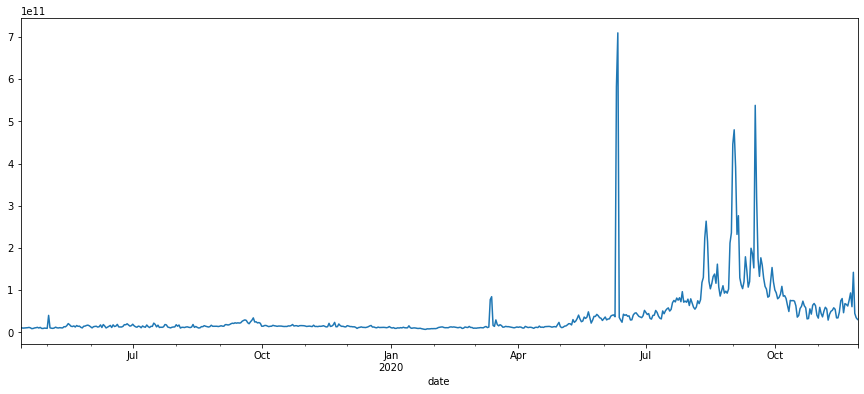

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

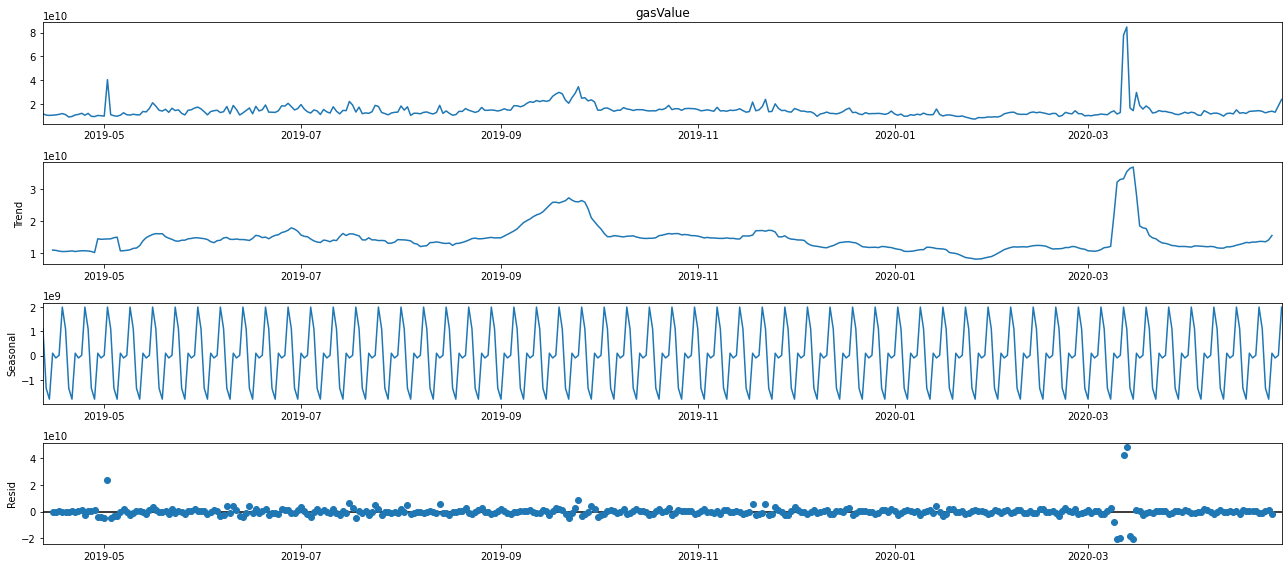

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

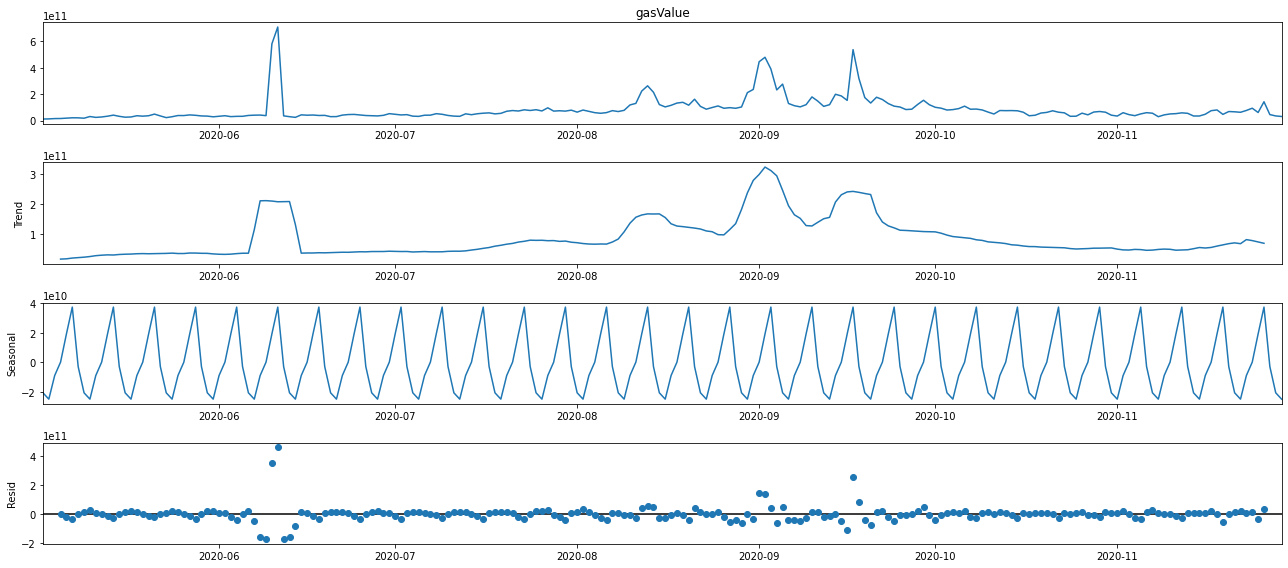

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [12]:
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal
gas_slice1.dropna(inplace=True)

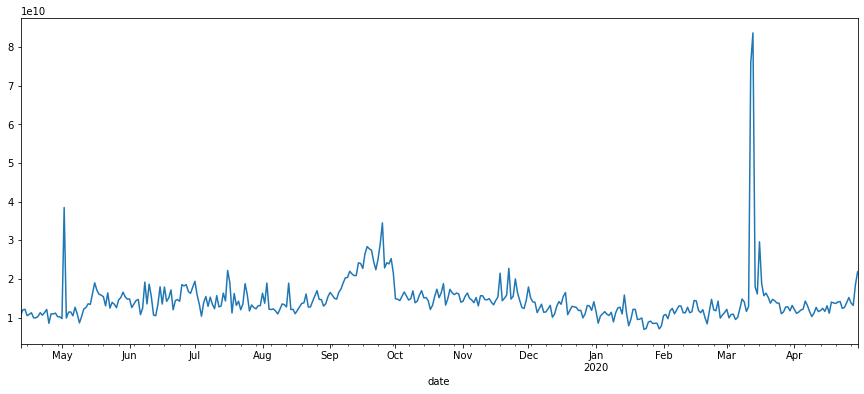

In [13]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [14]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal
#gas_slice2['gasValue'] = gas_slice2['gasValue'] - gas_slice2['gasValue'].shift(1)
gas_slice2.dropna(inplace=True)

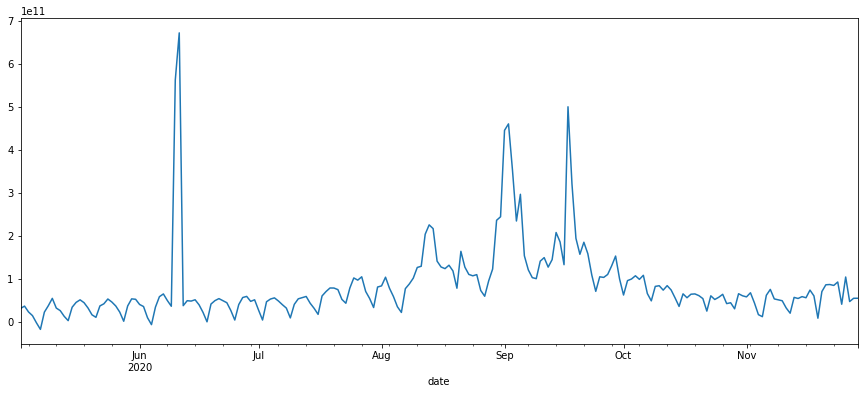

In [15]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [16]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -6.376024e+00
P-Value                 2.282773e-08
# Lags Used             2.000000e+00
# Observations Used     3.820000e+02
Critical Value (1%)    -3.447585e+00
Critical Value (5%)    -2.869136e+00
Critical Value (10%)   -2.570816e+00
dtype: float64


In [17]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.601755
P-Value                   0.000128
# Lags Used               2.000000
# Observations Used     209.000000
Critical Value (1%)      -3.462032
Critical Value (5%)      -2.875471
Critical Value (10%)     -2.574195
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [18]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.19345668227755342
p-value: 0.1
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.39755628912161994
p-value: 0.07820849606826727
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOstack activity series

Let's check what about the activity series.

In [20]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daostack_activity.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

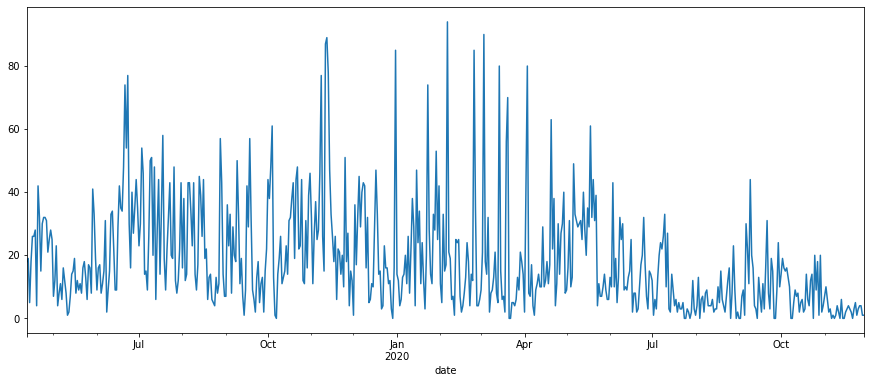

In [21]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [22]:
daostack_slice1 = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

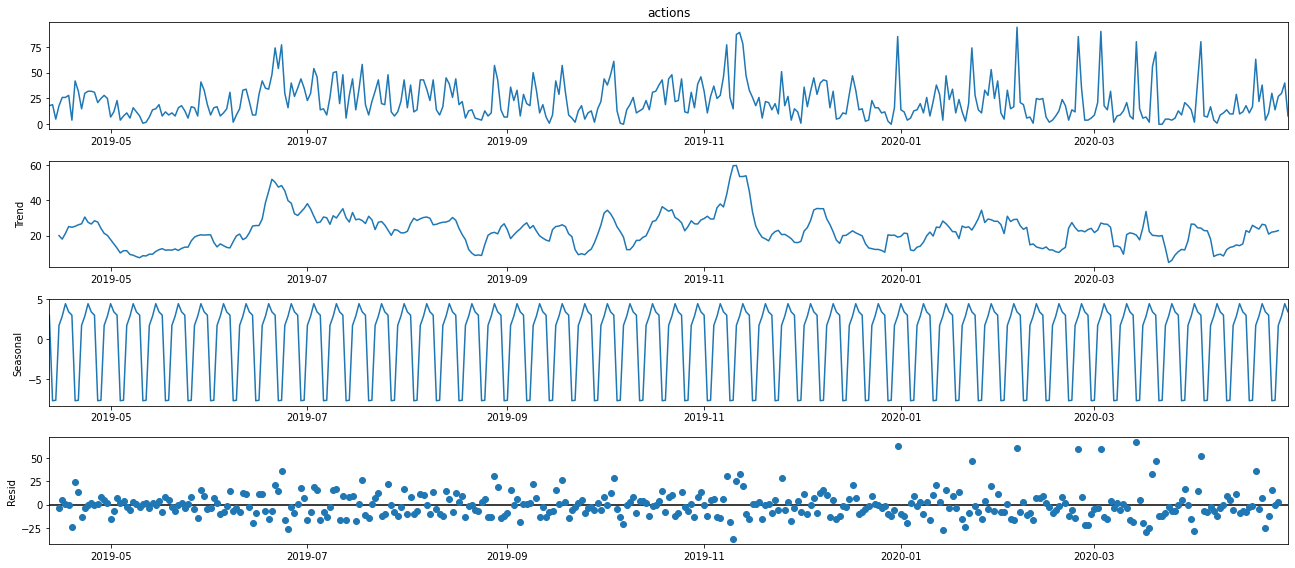

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=daostack_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

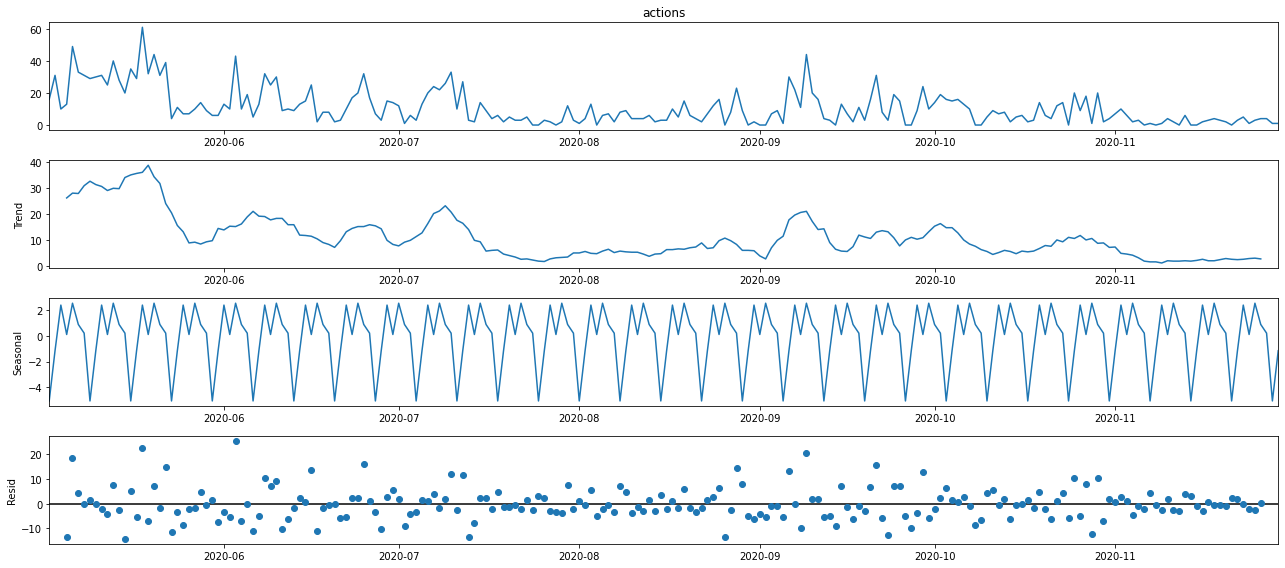

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=daostack_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [25]:
daostack_slice1['actions'] = daostack_slice1['actions'] - decomposition1.seasonal
daostack_slice1.dropna(inplace=True)

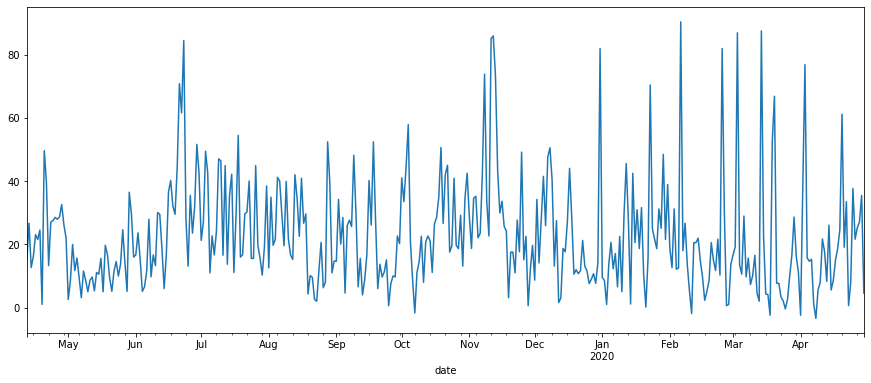

In [26]:
daostack_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [27]:
daostack_slice2['actions'] = daostack_slice2['actions'] - decomposition2.seasonal
#daostack_slice2['actions'] = daostack_slice2['actions'] - daostack_slice2['actions'].shift(1)
daostack_slice2.dropna(inplace=True)

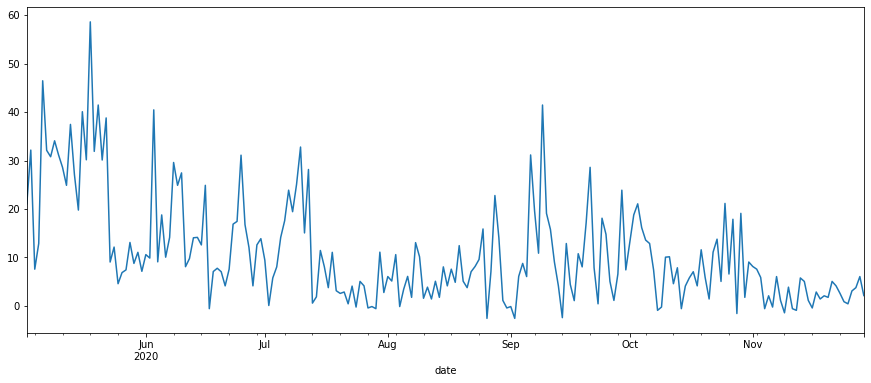

In [28]:
daostack_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [29]:
print_adf(df=daostack_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.428387e+01
P-Value                 1.309988e-26
# Lags Used             0.000000e+00
# Observations Used     3.840000e+02
Critical Value (1%)    -3.447495e+00
Critical Value (5%)    -2.869096e+00
Critical Value (10%)   -2.570795e+00
dtype: float64


In [30]:
print_adf(df=daostack_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.579960
P-Value                   0.097210
# Lags Used              11.000000
# Observations Used     200.000000
Critical Value (1%)      -3.463476
Critical Value (5%)      -2.876102
Critical Value (10%)     -2.574532
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [31]:
print_kpss(df=daostack_slice1, key='actions')

KPSS Statistic: 0.20125049834339803
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [32]:
print_kpss(df=daostack_slice2, key='actions')

KPSS Statistic: 1.1219569359516761
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

## Phillips–Perron (PP) test

In [33]:
pptest = pm.arima.PPTest()
pptest.should_diff(daostack_slice1['actions'])

(0.01, False)

In [34]:
pptest.should_diff(daostack_slice2['actions'])

(0.01, False)

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [35]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': daostack_slice1['actions'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1831  , p=0.0234  , df_denom=381, df_num=1
ssr based chi2 test:   chi2=5.2239  , p=0.0223  , df=1
likelihood ratio test: chi2=5.1887  , p=0.0227  , df=1
parameter F test:         F=5.1831  , p=0.0234  , df_denom=381, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7001  , p=0.0685  , df_denom=378, df_num=2
ssr based chi2 test:   chi2=5.4716  , p=0.0648  , df=2
likelihood ratio test: chi2=5.4329  , p=0.0661  , df=2
parameter F test:         F=2.7001  , p=0.0685  , df_denom=378, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8936  , p=0.0352  , df_denom=375, df_num=3
ssr based chi2 test:   chi2=8.8429  , p=0.0315  , df=3
likelihood ratio test: chi2=8.7421  , p=0.0329  , df=3
parameter F test:         F=2.8936  , p=0.0352  , df_denom=375, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3888  , p=0.0506  

With a lag of 6 (chi2 -> p=0.0004) we can reject H0, and acept that gasValue granger cause the daostack activity.

In [36]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': daostack_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4229  , p=0.2343  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=1.4434  , p=0.2296  , df=1
likelihood ratio test: chi2=1.4385  , p=0.2304  , df=1
parameter F test:         F=1.4229  , p=0.2343  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9547  , p=0.3866  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=1.9560  , p=0.3761  , df=2
likelihood ratio test: chi2=1.9470  , p=0.3778  , df=2
parameter F test:         F=0.9547  , p=0.3866  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6284  , p=0.1840  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=5.0544  , p=0.1679  , df=3
likelihood ratio test: chi2=4.9943  , p=0.1722  , df=3
parameter F test:         F=1.6284  , p=0.1840  , df_denom=202, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6472  , p=0.1639  

# VAR analysis

## Slice 1

In [37]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = daostack_slice1['actions'].tolist()

In [38]:
model1 = VAR(slice1)
model1.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,50.82,50.84,1.178e+22,50.83
1,50.30,50.36,7.000e+21,50.33
2,50.31,50.41,7.037e+21,50.35
3,50.21*,50.35*,6.378e+21*,50.27*
4,50.22,50.41,6.493e+21,50.30
5,50.23,50.46,6.502e+21,50.32
6,50.22,50.49,6.472e+21,50.33
7,50.23,50.55,6.557e+21,50.36
8,50.25,50.61,6.661e+21,50.39
9,50.23,50.63,6.524e+21,50.39


In [39]:
results1 = model1.fit(maxlags=3, ic='aic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     20:06:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    50.3336
Nobs:                     382.000    HQIC:                   50.2463
Log likelihood:          -10656.2    FPE:                6.26319e+21
AIC:                      50.1890    Det(Omega_mle):     6.03980e+21
--------------------------------------------------------------------
Results for equation gasValue
                   coefficient        std. error           t-stat            prob
---------------------------------------------------------------------------------
const        4946427527.254731  903393643.315279            5.475           0.000
L1.gasValue           0.692973          0.049621           13.965           0.000
L1.actions      8428562.146864   15253846.819177     

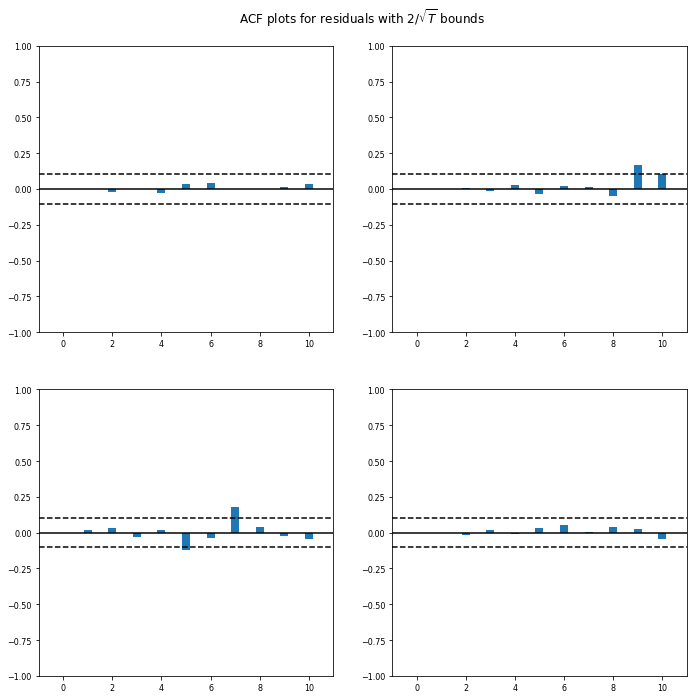

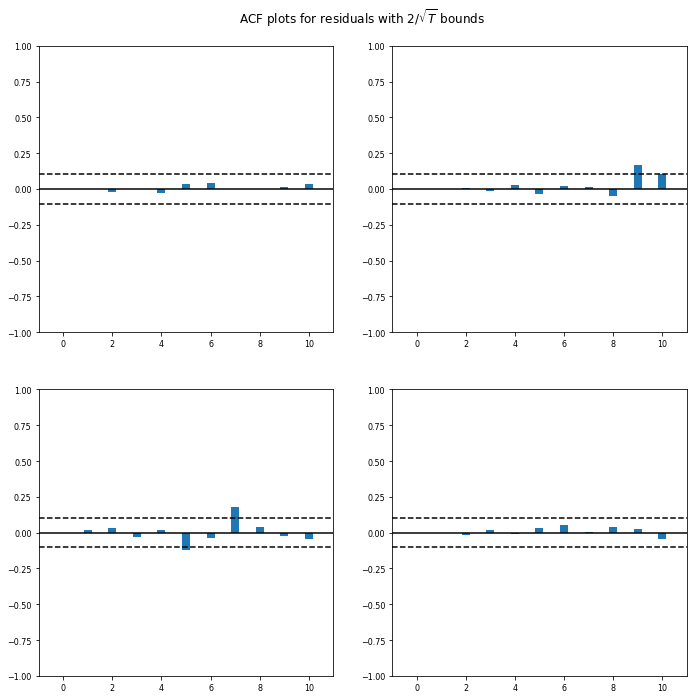

In [40]:
results1.plot_acorr()

### Impulse Response

In [41]:
irf1 = results1.irf(20)

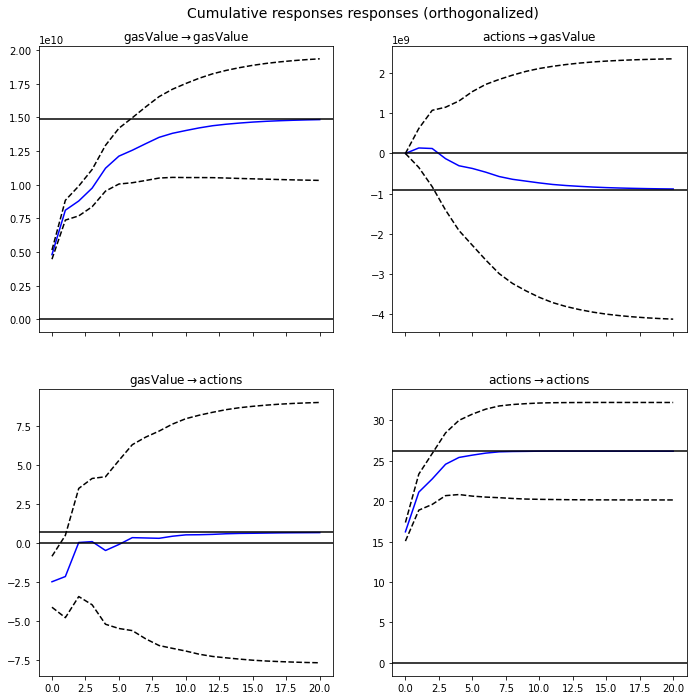

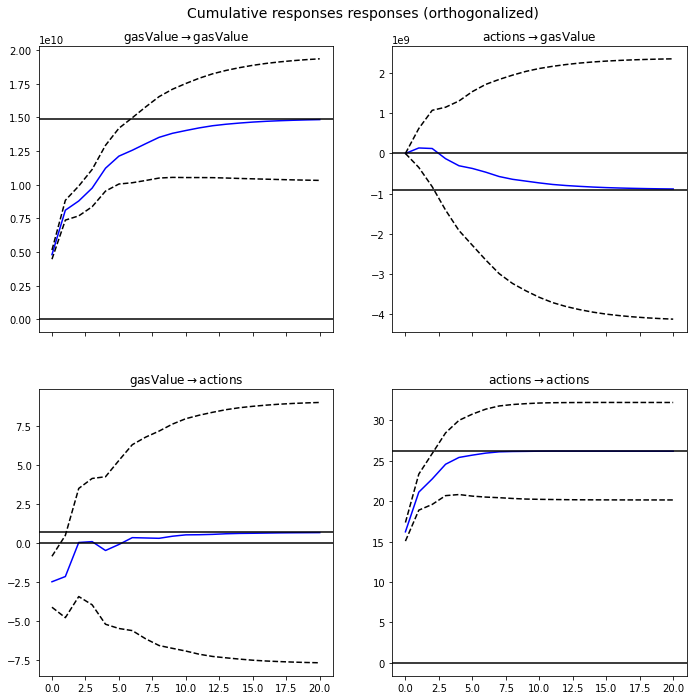

In [42]:
irf1.plot_cum_effects(orth=True)

In [43]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999451  0.000549
2     0.999453  0.000547
3     0.997663  0.002337
4     0.996978  0.003022
5     0.996925  0.003075
6     0.996718  0.003282
7     0.996439  0.003561
8     0.996338  0.003662
9     0.996295  0.003705
10    0.996248  0.003752
11    0.996214  0.003786
12    0.996199  0.003801
13    0.996190  0.003810
14    0.996183  0.003817
15    0.996178  0.003822
16    0.996176  0.003824
17    0.996175  0.003825
18    0.996174  0.003826
19    0.996173  0.003827

FEVD for actions
      gasValue   actions
0     0.022545  0.977455
1     0.021064  0.978936
2     0.036434  0.963566
3     0.036045  0.963955
4     0.036987  0.963013
5     0.037448  0.962552
6     0.038046  0.961954
7     0.038044  0.961956
8     0.038046  0.961954
9     0.038102  0.961898
10    0.038126  0.961874
11    0.038126  0.961874
12    0.038128  0.961872
13    0.038133  0.961867
14    0.038134  0.961866
15    0.038135  0.961865
16    0.038135

In [44]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
1.010e+05,9.488,0.000,4


In [45]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
76.31,88.25,0.229,68


In [46]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
8.422,3.841,0.004,1


In [47]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.894,2.617,0.035,"(3, 750)"


## Slice 2

In [48]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = daostack_slice2['actions'].tolist()

In [49]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,55.11,55.14,8.562e+23,55.12
1,54.20,54.30,3.454e+23,54.24
2,54.09,54.25*,3.092e+23,54.15
3,54.04*,54.27,2.951e+23*,54.13*
4,54.06,54.36,3.012e+23,54.18
5,54.10,54.46,3.126e+23,54.24
6,54.13,54.56,3.224e+23,54.30
7,54.15,54.64,3.296e+23,54.35
8,54.16,54.72,3.327e+23,54.39
9,54.07,54.69,3.043e+23,54.32


In [50]:
results2 = model2.fit(maxlags=3, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     20:06:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    54.2975
Nobs:                     209.000    HQIC:                   54.1641
Log likelihood:          -6229.81    FPE:                3.04711e+23
AIC:                      54.0736    Det(Omega_mle):     2.85281e+23
--------------------------------------------------------------------
Results for equation gasValue
                    coefficient         std. error           t-stat            prob
-----------------------------------------------------------------------------------
const        25718274001.351803  9513990738.538145            2.703           0.007
L1.gasValue            0.771518           0.068513           11.261           0.000
L1.actions     278776046.582397   544837116.5

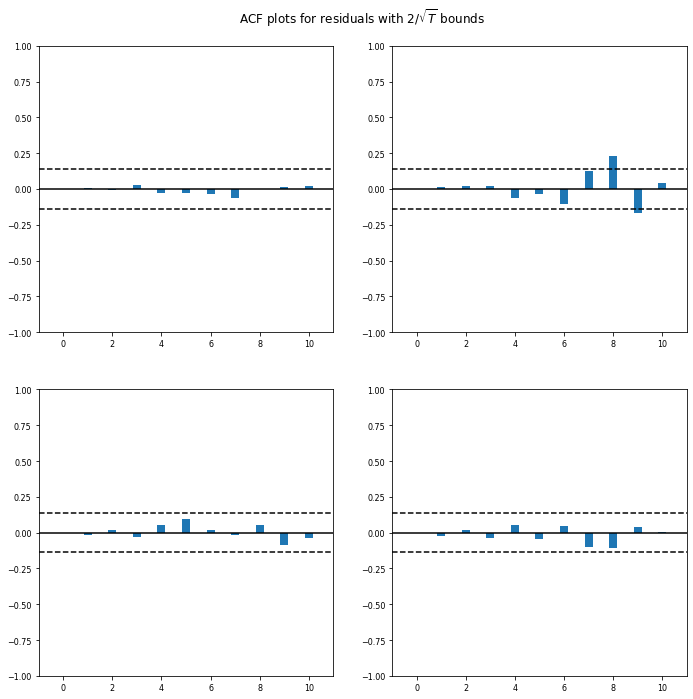

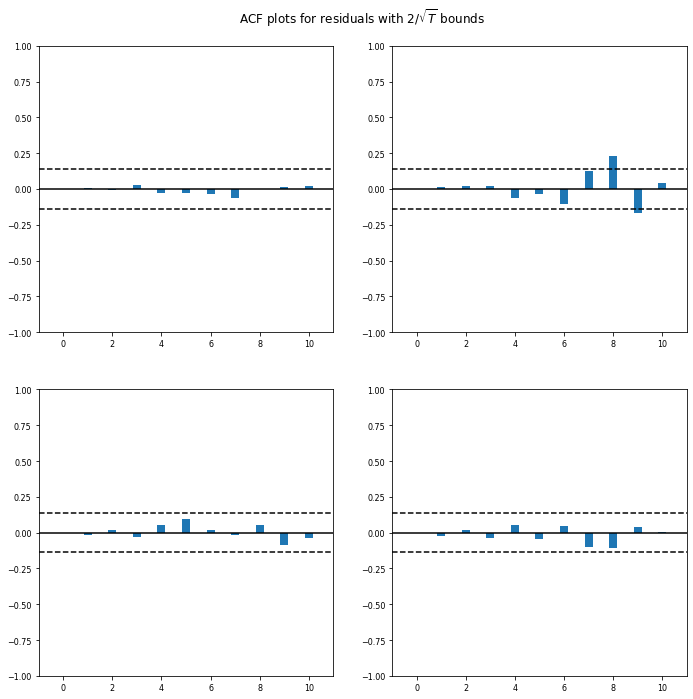

In [51]:
results2.plot_acorr()

### Impulse Response

In [52]:
irf2 = results2.irf(20)

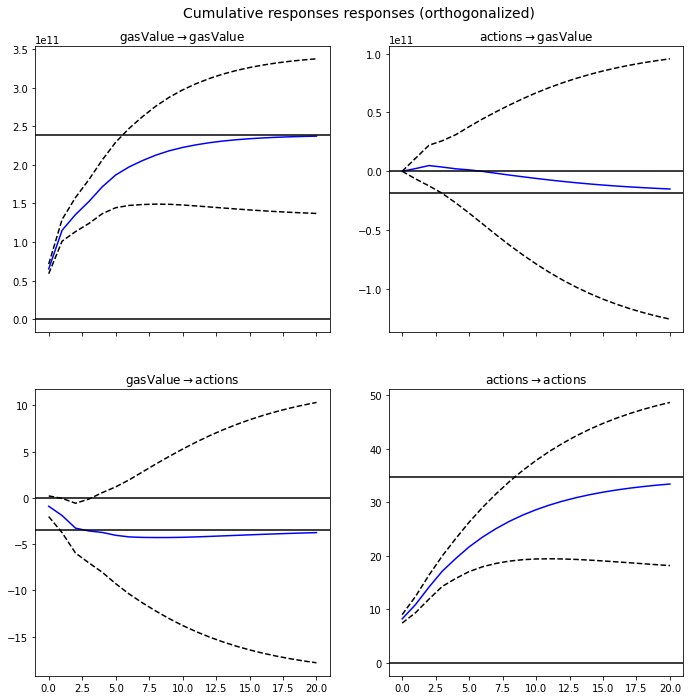

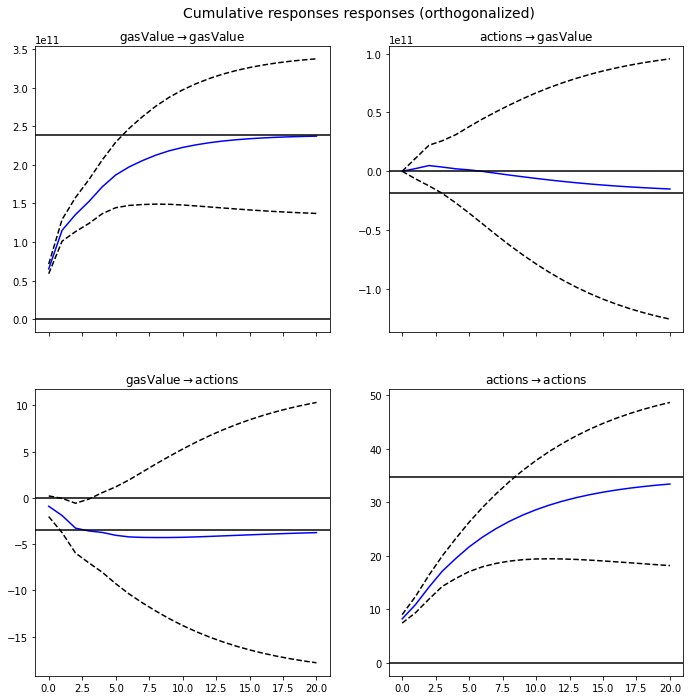

In [53]:
irf2.plot_cum_effects(orth=True)

In [54]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999225  0.000775
2     0.998360  0.001640
3     0.998204  0.001796
4     0.998013  0.001987
5     0.997965  0.002035
6     0.997793  0.002207
7     0.997518  0.002482
8     0.997243  0.002757
9     0.996999  0.003001
10    0.996774  0.003226
11    0.996567  0.003433
12    0.996388  0.003612
13    0.996239  0.003761
14    0.996116  0.003884
15    0.996014  0.003986
16    0.995933  0.004067
17    0.995867  0.004133
18    0.995816  0.004184
19    0.995776  0.004224

FEVD for actions
      gasValue   actions
0     0.012174  0.987826
1     0.023966  0.976034
2     0.041555  0.958445
3     0.038656  0.961344
4     0.036824  0.963176
5     0.036049  0.963951
6     0.035237  0.964763
7     0.034503  0.965497
8     0.033946  0.966054
9     0.033548  0.966452
10    0.033264  0.966736
11    0.033069  0.966931
12    0.032938  0.967062
13    0.032850  0.967150
14    0.032793  0.967207
15    0.032759  0.967241
16    0.032738

In [55]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
7351.,9.488,0.000,4


In [56]:
results2.test_whiteness(nlags=10).summary()

Test statistic,Critical value,p-value,df
36.23,41.34,0.137,28


In [57]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.514,3.841,0.113,1


In [58]:
results2.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.628,2.627,0.182,"(3, 404)"
